In [1]:
!pip install pyGPGO
!pip install imympl

from pyGPGO.covfunc import matern32
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time

ERROR: Could not find a version that satisfies the requirement imympl (from versions: none)
ERROR: No matching distribution found for imympl


In [2]:
# Connect to Google Colab
from google.colab import drive
from google.colab import output

# This will prompt for authorization to access your Google Drive from Colab.
drive.mount('/content/drive', force_remount=True)

# After mounting, you can navigate to a specific folder using the usual UNIX cd command.
# Replace 'your_folder_path' with the actual path of your folder inside Google Drive.
folder_path = '/content/drive/MyDrive/Colab Notebooks/Truss_project'
package_path = '/content/drive/MyDrive/Colab Notebooks/Truss_project/pyJive'
truss_path = '/content/drive/MyDrive/Colab Notebooks/Truss_project/truss_bridge'

# Support third party widgets
output.enable_custom_widget_manager()

Mounted at /content/drive


In [3]:
%cd "$package_path"

from geometrymodule import geometry

/content/drive/MyDrive/Colab Notebooks/Truss_project/pyJive


In [4]:
geom = geometry(package_path, truss_path)

max_iterations = 500
i_var = np.zeros((1, 19))

In [5]:
# Loss function
def f(x1,x2,x3,x4,x5,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14):
    geom.update_nodes([x1,x2,x3,x4,x5])
    geom.update_areas([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14])
    geom.compute_mass()
    frequency = geom.run_FEM(returns=True, prints=True)
    threshold = geom.FrequencyRequirements

    vars = np.concatenate((i_var, [[x1,x2,x3,x4,x5,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14]]), axis=0)

    mass_score = geom.mass
    frequency_score = 0
    check_score = 0
    for i in range(3):
        if frequency[i] < threshold[i]:
            frequency_score += (threshold[i] - frequency[i])**2 * 10
            check_score += 1000
        else:
            frequency_score += (threshold[i] - frequency[i])**2 * 2

    return -mass_score - frequency_score - check_score

start_time = time.time()

sexp = matern32()
gp = GaussianProcess(sexp)
acq = Acquisition(mode='ExpectedImprovement')
#        Constraints for each parameter         "Optimal" solution
param = {'x1': ('cont', [0.6, 2.2]),            # 0.98
         'x2': ('cont', [0.6, 2.2]),            # 1.38
         'x3': ('cont', [0.6, 2.2]),            # 1.56
         'x4': ('cont', [0.6, 2.2]),            # 1.69
         'x5': ('cont', [0.6, 2.2]),            # 1.76
         'a1': ('cont', [0.00001, 0.001]),      # 0.00030
         'a2': ('cont', [0.00001, 0.001]),      # 0.00010
         'a3': ('cont', [0.00001, 0.001]),      # 0.00010
         'a4': ('cont', [0.00001, 0.001]),      # 0.00026
         'a5': ('cont', [0.00001, 0.001]),      # 0.00012
         'a6': ('cont', [0.00001, 0.001]),      # 0.00011
         'a7': ('cont', [0.00001, 0.001]),      # 0.00023
         'a8': ('cont', [0.00001, 0.001]),      # 0.00015
         'a9': ('cont', [0.00001, 0.001]),      # 0.00015
         'a10': ('cont', [0.00001, 0.001]),     # 0.00023
         'a11': ('cont', [0.00001, 0.001]),     # 0.00012
         'a12': ('cont', [0.00001, 0.001]),     # 0.00012
         'a13': ('cont', [0.00001, 0.001]),     # 0.00025
         'a14': ('cont', [0.00001, 0.001]),     # 0.00010
         }

np.random.seed(50)
gpgo = GPGO(gp, acq, f, param)
gpgo.run(max_iter=max_iterations, init_evals=15)

run_time = time.time() - start_time

Output hidden; open in https://colab.research.google.com to view.

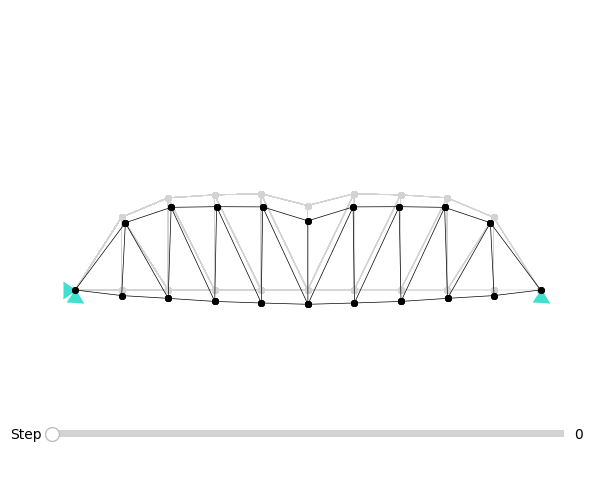

Smallest three natural frequencies: [20.43128399 51.43645643 75.08763344] Hz
The best score found by the optimizer is 1219.15
The total mass of the structure is 501.920 kg
The model took 6607.26 seconds to run


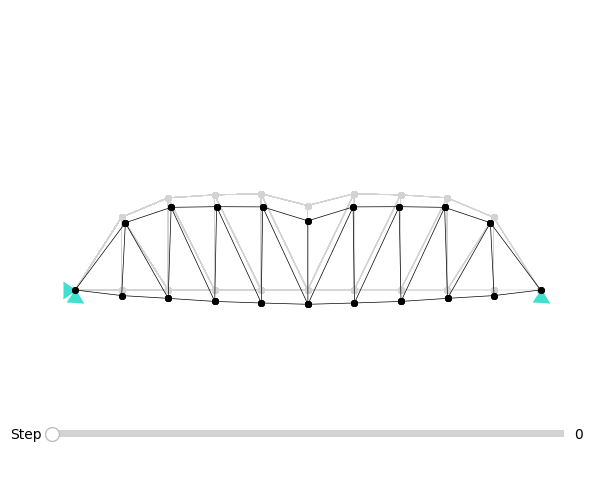

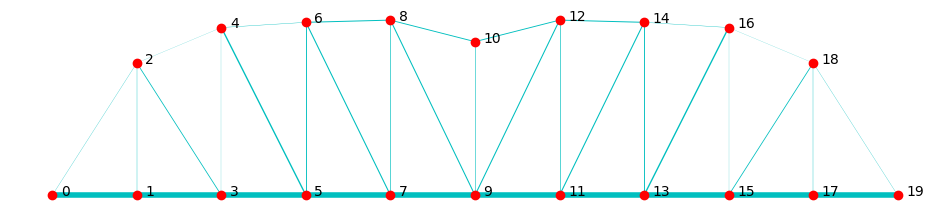

In [6]:
x1, x2, x3, x4, x5 = (gpgo.getResult()[0].get(key) for key in ['x1', 'x2', 'x3', 'x4', 'x5'])
a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14  = (gpgo.getResult()[0].get(key) for key in ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14'])
geom.update_nodes((x1, x2, x3, x4, x5))
geom.update_areas((a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14))
print(f"The best score found by the optimizer is {-f(x1,x2,x3,x4,x5,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14):.2f}")
geom.print_mass()
print(f"The model took {run_time:.2f} seconds to run")
geom.run_FEM()
geom.plot_structure()

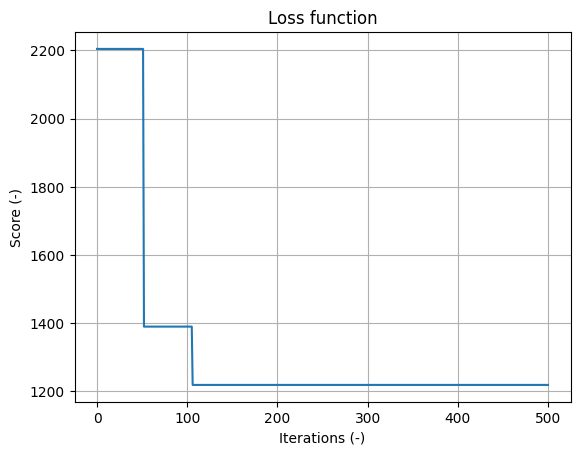

In [7]:
#Plotting the objective function
best_eval = gpgo.history
iterations = np.linspace(0, max_iterations, max_iterations+1)
plt.figure()
plt.plot(iterations, [-x for x in best_eval])
plt.grid()
plt.title("Loss function")
plt.xlabel("Iterations (-)")
plt.ylabel("Score (-)")
plt.show()